# Train colorizer using danbooru with pre-generated linearts

In [2]:
import math, gc, os
from pathlib import Path
from typing import Tuple
from math import tau,pi
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage

import fastai.basics as fai
import fastai.data.all as fd
import fastai.vision.all as fv
import fastai.vision.gan as fgan
from fastprogress.fastprogress import NBProgressBar

from model import *

In [3]:
path_sb_color = Path("path/to/color/images")
path_sb_la = Path("path/to/lineart/images")

def get_y(fname: Path):
    mod1000 = int(fname.stem)%1000
    return path_sb_color/f"{mod1000:04d}"/fname.name

In [4]:
def get_hint(name: Path):
    if path_sb_la in name.parents:
        hintname = get_y(name)
    else:
        hintname = name.with_name(name.stem+"_CH").with_suffix(name.suffix)
    return fv.PILImage.create(hintname)

def ColorHintBlock():
    return fv.TransformBlock(type_tfms=get_hint, batch_tfms=fv.IntToFloatTensor)

In [5]:
@fai.typedispatch
def show_batch(x:Tuple, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = fv.get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize, double=True)
    for i in range(2):
        ctxs[i::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i*2),ctxs[i::2],range(max_n))]
    return ctxs

@fai.typedispatch
def show_results(x:Tuple, y, samples, outs, ctxs=None, max_n=10, figsize=None, **kwargs):
    if ctxs is None: ctxs = fv.get_grid(3*min(len(samples), max_n), ncols=3, figsize=figsize, title='Input/Target/Prediction')
    for i in range(2):
        ctxs[i::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i*2),ctxs[i::3],range(max_n))]
    ctxs[2::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(0),ctxs[2::3],range(max_n))]
    return ctxs

In [6]:
def load_data(path,size,bs):
    tfms = fv.aug_transforms(size=size, max_rotate=20., max_warp=0.1, max_lighting=0.1)
    dblock = fd.DataBlock( blocks    = (fv.ImageBlock, ColorHintBlock, ImageBlockHHSV(PILImageOutput)),
                           get_items = fv.get_image_files,
                           get_y     = get_y,
                           splitter  = fai.RandomSplitter(0.01, 42),
                           item_tfms = fv.Resize(size),
                           batch_tfms= tfms 
                          )
    return dblock.dataloaders(path,bs=bs)

In [10]:
data = load_data(path_sb_la, (256,256), 10)

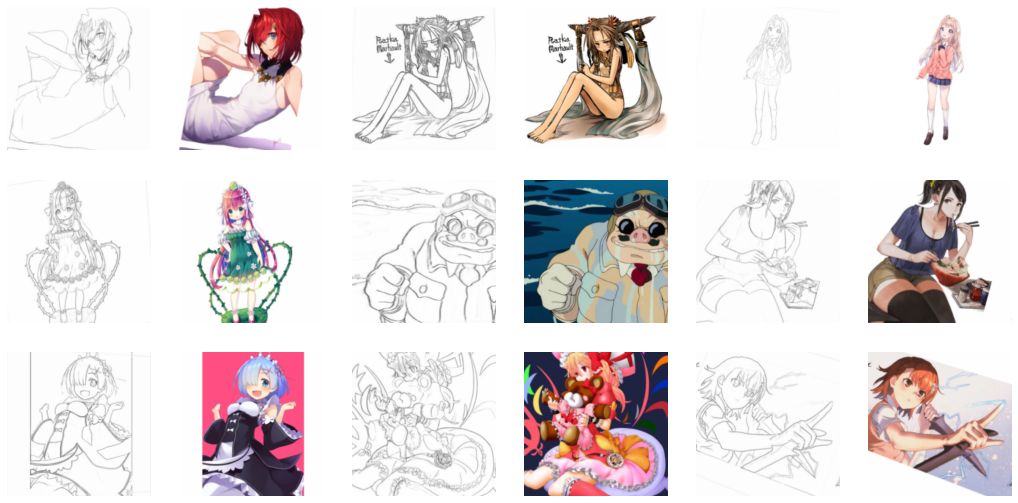

In [218]:
data.show_batch()

In [8]:
model = get_model(64).cuda()
num_params(model)

7943588

In [11]:
MODEL_NAME = "ColorizeLA"
learn = fv.Learner(data , model, loss_func=model.loss_func, opt_func=fv.ranger,
                   cbs=[fv.GradientClip()])

In [ ]:
learn.fit_one_cycle(10, 3e-3, div=0.95, pct_start=0.5)
learn.save(MODEL_NAME+"stage_1")

# With Perceptual loss

In [9]:
from perceptualloss import PerceptualLoss
from xyvvgg import get_xyvvgg

In [10]:
vgg = get_xyvvgg("models/xyv_vgg.pth")[1:].cuda()
vgg = vgg.eval()

In [11]:
good_layers = [i for i,o in enumerate(vgg) if isinstance(o,nn.MaxPool2d)] + [31-5]
good_layers

[3, 9, 18, 26]

In [12]:
vgg = vgg[:good_layers[-1]+1]

In [13]:
p_loss = PerceptualLoss(vgg, good_layers,
                         content_weights=[.04,.12,.18,.6],
                         style_weights=[.04,.12,.14,.05],
                         style_mult=200
                        )

In [14]:
def xyv_perceptual_loss(yp, y):
    ye = model.unet.cm__hd
    yd = F.interpolate(y, size=ye.shape[2:], mode='bilinear', align_corners=False)
    yd = rgb2hhsv(yd)
    return 4*F.mse_loss(yp, rgb2hhsv(y)) +2*F.mse_loss(ye, yd) + p_loss(hhsv2xyv(yp), rgb2xyv(y))
learn.loss_func = xyv_perceptual_loss

In [ ]:
learn.fit_one_cycle(3, 2e-4, div=0.95, pct_start=0.5)
learn.save(MODEL_NAME + "_after_perceptual")

# Check Results

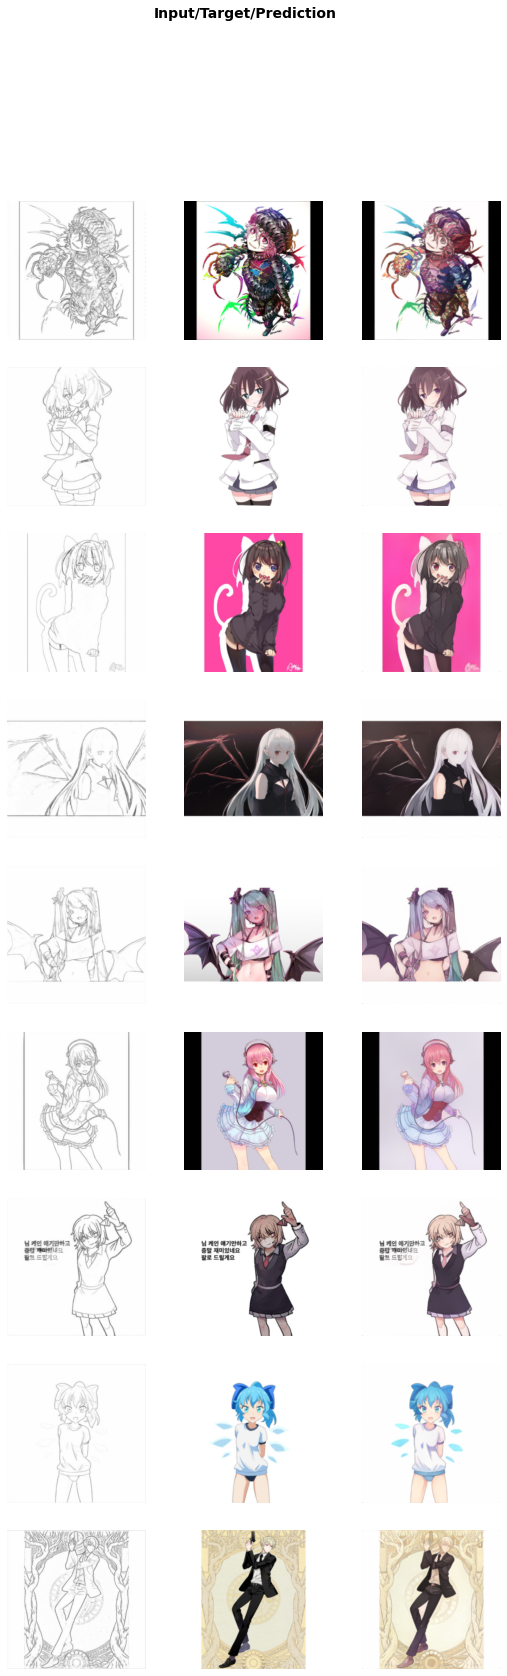

In [217]:
# Show colorization results from the Dataset
learn.show_results()

<AxesSubplot:>

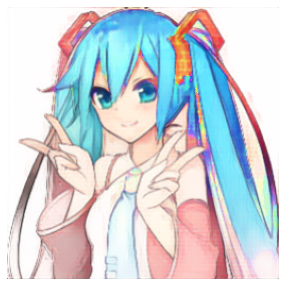

In [46]:
# Predcit a single image (the reference image must be on the same dir and have a _CH suffix)
# eg. to predict path/img.jpg color ref must exist path/img_CH.jpg
res = learn.predict(Path("path/to/image.jpg"))
res[0].show()

In [190]:
# Time the excecution of colorizing 1 image
x, h, y  = data.one_batch()
x, h = x[0:1], h[0:1]
with torch.no_grad():
    %timeit -n 10 res = learn.dls.decode((x, h,learn.model(x,h)))[2][0]

41 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [189]:
# Time the excecution of colorizing a batch (10) images
x, h, y  = data.one_batch()
with torch.no_grad():
    %timeit -n 10 res = learn.dls.decode((x, h,learn.model(x,h)))[2]

85.9 ms ± 796 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
# Export for future inference
learn.export("models/colorizer.pkl")

## GANS

### Pre-train Discriminator

In [7]:
## save preds
def save_preds(learn, save_dir, bs=64):
    allitems = learn.dls[0].dataset.items + learn.dls[1].dataset.items
    dl = learn.dls.test_dl(allitems, rm_type_tfms=None, num_workers=0, bs=bs)
    learn.model.eval()
    for it, batch in enumerate(NBProgressBar(dl)):
        with torch.no_grad():
            preds = [ToPILImage()(p) for p in hhsv2rgb(learn.model(*batch))]
        for img, fname in zip(preds, allitems[it*bs:]):
            img.save(save_dir/fname.name)

In [10]:
generateds_path = Path("path/to/save/generateds")
save_preds(learn, generateds_path)

In [11]:
def get_ydisc(x):
    return "Fake" if generateds_path in x.parents else "Real"

def get_some_image_files(path, amount=0.5):
    files = fv.get_image_files(path)
    n = len(files)
    return files[:int(n*amount)]

def load_data_disc(path,size,bs):
    tfms = fv.aug_transforms(size=size, max_rotate=20., max_warp=0.1, max_lighting=0.2)
    dblock = fd.DataBlock( blocks    = (ImageBlockHHSV(PILImageInput), fv.CategoryBlock(["Fake", "Real"], sort=False)),
                           get_items = lambda x : get_some_image_files(path_sb_color) + get_some_image_files(generateds_path),
                           get_y     = get_ydisc,
                           splitter  = fai.RandomSplitter(0.02, 42),
                           item_tfms = fv.Resize(size),
                           batch_tfms= tfms 
                          )
    return dblock.dataloaders(path,bs=bs)

In [12]:
class HHSV2XYV(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x):
        return hhsv2xyv(x)
discriminator = nn.Sequential(HHSV2XYV(), *cab(3,64), ResBlock(64), ResBlock(64),
                              ResBlock(64, 128, s=2), ResBlock(128), ResBlock(128),
                              *cab(128, 256, s=2), ResBlock(256), ResBlock(256),
                              *cab(256, 512, s=2),
                              nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                              nn.Flatten(), nn.Linear(512,1)).cuda()
disc_loss = fgan.AdaptiveLoss(nn.BCEWithLogitsLoss())
num_params(discriminator)

3247681

In [ ]:
datadisc = load_data_disc(Path("./"), 256, 8)
learndisc = fv.Learner(datadisc, discriminator, loss_func=disc_loss, opt_func=fv.ranger)
learndisc.fit_one_cycle(10, 1e-3, div=0.95, pct_start=0.5)
torch.save(discriminator.state_dict(), "models/disc_stage1")

In [13]:
def req_grad(m, v):
    for param in m.parameters():
        param.requires_grad = v

In [14]:
#train loop
class GAN:
    def __init__(self, data, learn, disc, lam=1e-3):
        fv.store_attr()
        self.iters_inner = 0
        self.train_gen = True
        
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), 5e-5, weight_decay=1e-2)
        del self.learn.opt
        self.learn.opt = torch.optim.Adam(learn.model.parameters(), 1e-5, weight_decay=1e-2)
        
        self.set_trainable()
        self.model_died_count = 0
        self.batch_count = 0
    
    def epoch(self):
        nbp = NBProgressBar(self.data[0])
        
        for x,h,y in nbp:
            self.learn.opt.zero_grad()
            self.disc_opt.zero_grad()
            
            ones = torch.ones(self.data.bs, device=y.device)
            zeros = torch.zeros(self.data.bs, device=y.device)

            ypred = self.learn.model(x, h)

            if self.train_gen: 
                d_pred = self.disc(ypred)
                loss = self.learn.loss_func(ypred, y) + self.lam*disc_loss(d_pred, ones)
                loss.backward()
                self.learn.opt.step()
                
            else:
                ypred = ypred.detach().requires_grad_(False)
                ypc, yc = self.disc(ypred), self.disc(y)
                loss = (disc_loss(ypc, zeros) + disc_loss(yc, ones))/2.0
                loss.backward()
                self.disc_opt.step()
            
            self.iters_inner += 1
            
            if math.isnan(loss):
                self.model_died_count += 1
                print(f"Model died at iter {self.iters_inner}")
                return False
            
            # switch if needd
            if self.batch_count >= 1000:
                self.train_gen = not(self.train_gen)
                self.set_trainable()
        
        return True
    
    def set_trainable(self):
        if self.train_gen:
            self.learn.model.train()
            self.disc.eval()
        else:
            self.learn.model.eval()
            self.disc.train()
        req_grad(self.learn.model, self.train_gen)
        req_grad(self.disc, not(self.train_gen))
        self.batch_count = 0
        gc.collect()
        torch.cuda.empty_cache()
                
    
    def save(self, name):
        torch.save(self.disc.state_dict(), f"models/{MODEL_NAME}_disc_{name}.pth")
        torch.save(self.learn.model.state_dict(), f"models/{MODEL_NAME}_gen_{name}.pth")
        
    def load(self, name):
        self.disc.load_state_dict(torch.load(f"models/{MODEL_NAME}_disc_{name}.pth"))
        self.learn.model.load_state_dict(torch.load(f"models/{MODEL_NAME}_gen_{name}.pth"))

In [ ]:
g = GAN(data, learn, discriminator)
for i in range(10):
    g.epoch()

## FID

In [ ]:
generateds_path = Path("path/to/save/generateds")
save_preds(learn, generateds_path)

In [17]:
fakes = fv.get_image_files(generateds_path)
reals = fv.get_image_files(path_sb_color)

In [21]:
# Requires https://github.com/mseitzer/pytorch-fid
# or
# pip install pytorch-fid
from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_activation_statistics, calculate_frechet_distance
DIMS = 2048
BS = 50
NUM_WORKERS = 8
DEVICE = torch.device("cuda:0")
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[DIMS]
INCEPTION = InceptionV3([block_idx]).to(DEVICE)

m1, s1 = calculate_activation_statistics(reals, INCEPTION, BS, DIMS, DEVICE, NUM_WORKERS)
m2, s2 = calculate_activation_statistics(fakes, INCEPTION, BS, DIMS, DEVICE, NUM_WORKERS)

fid_value = calculate_frechet_distance(m1, s1, m2, s2)
fid_value

30.039864004805167